# 02_temp_by_urban_typologies

This notebook explores temperature data in __different selected urban environments in Monterrey__ in order to find interesting facts and relations for further analysis and dissemination.

## __Import libraries__

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/observatorio/Documents/repos/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Round up numbers [math.ceil(4.2)]
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## __Notebook config__

In [3]:
city = 'Monterrey'
projected_crs = "EPSG:32613"
res = 10
# Filter for urban areas only
filter_urban = True
# Save resulting plots?
#save_plots = True
# Save resulting tables for GIS analysis?
#save_output = True

## __Load data__

### __Load data__ - Hexs

In [4]:
hex_schema = 'hexgrid'
hex_table = f'hexgrid_{res}_city_2020'

if filter_urban:
    hex_type = 'urban'
    query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\' AND \"type\" = '{hex_type}\'"
else:
    query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\'"

# Read and format cols
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
hex_gdf['res'] = res
hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
hex_gdf.to_crs(projected_crs,inplace=True)
# List all unique hex_ids
hexid_lst = list(hex_gdf.hex_id.unique())

# Show
print(f"{len(hexid_lst)} unique hex_ids.")
print(hex_gdf.crs)
hex_gdf.head(2)

58103 unique hex_ids.
EPSG:32613


,hex_id,geometry,res
0,8a48a20d499ffff,"POLYGON ((988515.871 2858080.013, 988582.39 28...",10
1,8a48a20cc327fff,"POLYGON ((976749.272 2864297.468, 976815.81 28...",10


### __Load data__ - Urban typologies

In [5]:
urban_typ = gpd.read_file(str(project_root)+f"/data/external/urban_typologies_mty/sitios_interes_mty.gpkg")

# Show
print(urban_typ.crs)
print(urban_typ.shape)
urban_typ.head(2)

EPSG:32613
(10, 3)


,name,site,geometry
0,Habitacional suburbano,"Hacienda del Sol, García","POLYGON ((943595.649 2861956.154, 943556.517 2..."
1,Originario,Centro de García,"POLYGON ((942546.446 2862632.14, 941464.296 28..."


<Axes: >

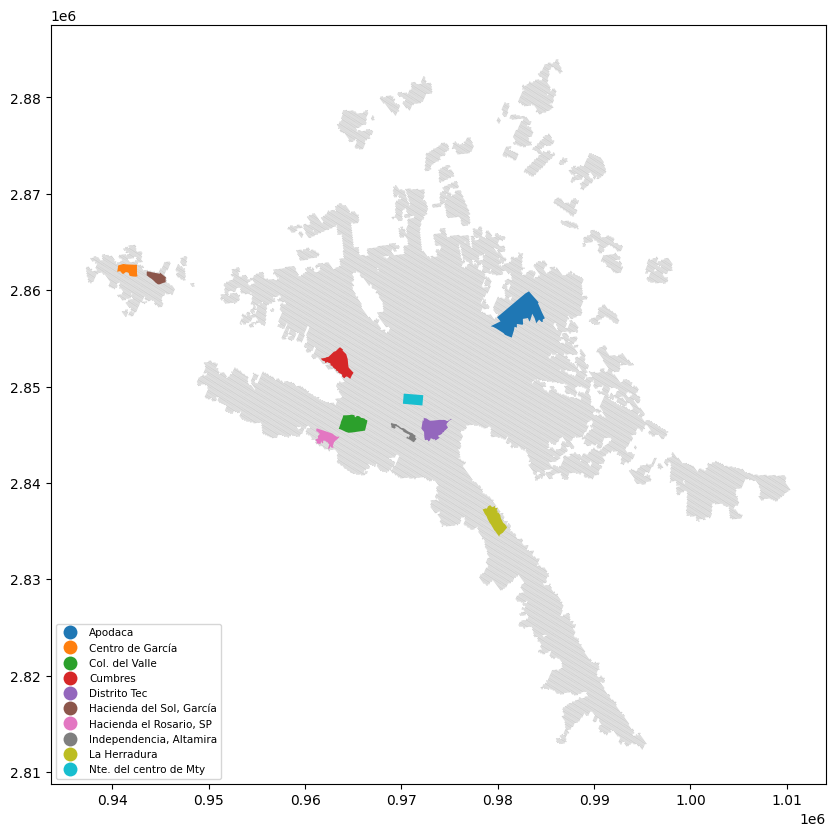

In [7]:
fig,ax = plt.subplots(figsize=(10,10))

urban_typ.plot('site', 
               legend=True,
               legend_kwds={'fontsize':7.5,'loc':'lower left'},
               ax=ax,
               zorder=1
              )
hex_gdf.plot(color='lightgrey',
             ax=ax,
             zorder=0)

### __Load data__ - Temperature

In [8]:
temp_schema = 'raster_analysis'
temp_table = 'temperature_analysis_hex'

query = f"SELECT * FROM {temp_schema}.{temp_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
temperature_gdf = aup.gdf_from_query(query, geometry_col='geometry')
temperature_gdf.to_crs(projected_crs,inplace=True)

# Filter for urban areas if required
if filter_urban:
    temperature_gdf = temperature_gdf.loc[temperature_gdf.hex_id.isin(hexid_lst)].copy()

infs = temperature_gdf.loc[np.isinf(temperature_gdf['temperature_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    temperature_gdf = temperature_gdf.loc[~np.isinf(temperature_gdf['temperature_mean'])].copy()

# Show
print(temperature_gdf.crs)
print(temperature_gdf.shape)
temperature_gdf.head(2)

EPSG:32613
(58103, 17)


,hex_id,geometry,res,temperature_mean,temperature_std,temperature_median,temperature_max,temperature_min,temperature_diff,temperature_tend,temperature_2018,temperature_2019,temperature_2020,temperature_2021,temperature_2022,temperature_2023,city
275,8a48a2002007fff,"POLYGON ((982709.57 2843581.326, 982776.112 28...",10,32.266927,8.708856,33.383929,42.308036,18.632440,23.675595,0.121705,32.819643,28.663690,31.678571,31.851190,31.342262,35.836607,Monterrey
276,8a48a200200ffff,"POLYGON ((982624.843 2843697.048, 982691.385 2...",10,32.534831,8.632499,33.441406,42.483073,18.898438,23.584635,0.130380,32.990625,28.842448,31.934896,32.095052,31.674479,36.184375,Monterrey


### __Load data__ - NDVI

In [9]:
ndvi_schema = 'raster_analysis'
ndvi_table = 'ndvi_analysis_hex'

query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
ndvi_gdf.to_crs(projected_crs,inplace=True)

# Filter for urban areas if required
if filter_urban:
    ndvi_gdf = ndvi_gdf.loc[ndvi_gdf.hex_id.isin(hexid_lst)].copy()

infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()

# Show
print(ndvi_gdf.crs)
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

EPSG:32613
(58103, 17)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city
275,8a48a2002007fff,"POLYGON ((982709.57 2843581.326, 982776.112 28...",10,0.085640,0.019116,0.087677,0.108141,0.067543,0.040599,-0.000420,0.088796,0.095076,0.101948,0.095281,0.060746,0.071994,Monterrey
276,8a48a200200ffff,"POLYGON ((982624.843 2843697.048, 982691.385 2...",10,0.147468,0.042202,0.159092,0.184561,0.114989,0.069572,-0.001576,0.187372,0.178460,0.174966,0.145590,0.095199,0.103221,Monterrey


### __Load data__ - NDMI

In [10]:
ndmi_schema = 'raster_analysis'
ndmi_table = 'ndmi_analysis_hex'

query = f"SELECT * FROM {ndmi_schema}.{ndmi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
ndmi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
ndmi_gdf.to_crs(projected_crs,inplace=True)

# Filter for urban areas if required
if filter_urban:
    ndmi_gdf = ndmi_gdf.loc[ndmi_gdf.hex_id.isin(hexid_lst)].copy()

infs = ndmi_gdf.loc[np.isinf(ndmi_gdf['ndmi_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    ndmi_gdf = ndmi_gdf.loc[~np.isinf(ndmi_gdf['ndmi_mean'])].copy()

# Show
print(ndmi_gdf.crs)
print(ndmi_gdf.shape)
ndmi_gdf.head(2)

EPSG:32613
(58103, 17)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndmi_2018,ndmi_2019,ndmi_2020,ndmi_2021,ndmi_2022,ndmi_2023,city
275,8a48a2002007fff,"POLYGON ((982709.57 2843581.326, 982776.112 28...",10,0.003053,0.018662,0.005473,0.030532,-0.024698,0.055230,0.000173,-0.004958,0.003311,0.008389,-0.004974,0.009539,0.007009,Monterrey
276,8a48a200200ffff,"POLYGON ((982624.843 2843697.048, 982691.385 2...",10,0.007137,0.019723,0.005018,0.039185,-0.019907,0.059091,-0.000170,0.014329,0.014443,0.014508,-0.005965,0.001178,0.004327,Monterrey


## __Analysis__

### __Analysis 01__ Temperature anomalies in Monterrey plot

In [11]:
list(urban_typ.name.unique())

['Habitacional suburbano',
 'Originario',
 'Centro urbano consolidado 1',
 'Asentamientos irregulares',
 'Residencial consolidado',
 'Residencial montaña',
 'Industrial',
 'Centro urbano consolidado 2',
 'Residencial suburbano',
 'Transformación']

Mean temperature in Monterrey: 35.205747095108535.


Text(0.5, 1.0, '\nTemperature anomaly in Monterrey. \nMean city temperature: 35.21\nMin. anomaly: -12.7\nMean anomaly: -0.0\nMedian anomaly: 0.47\nMax. anomaly: 13.06\n')

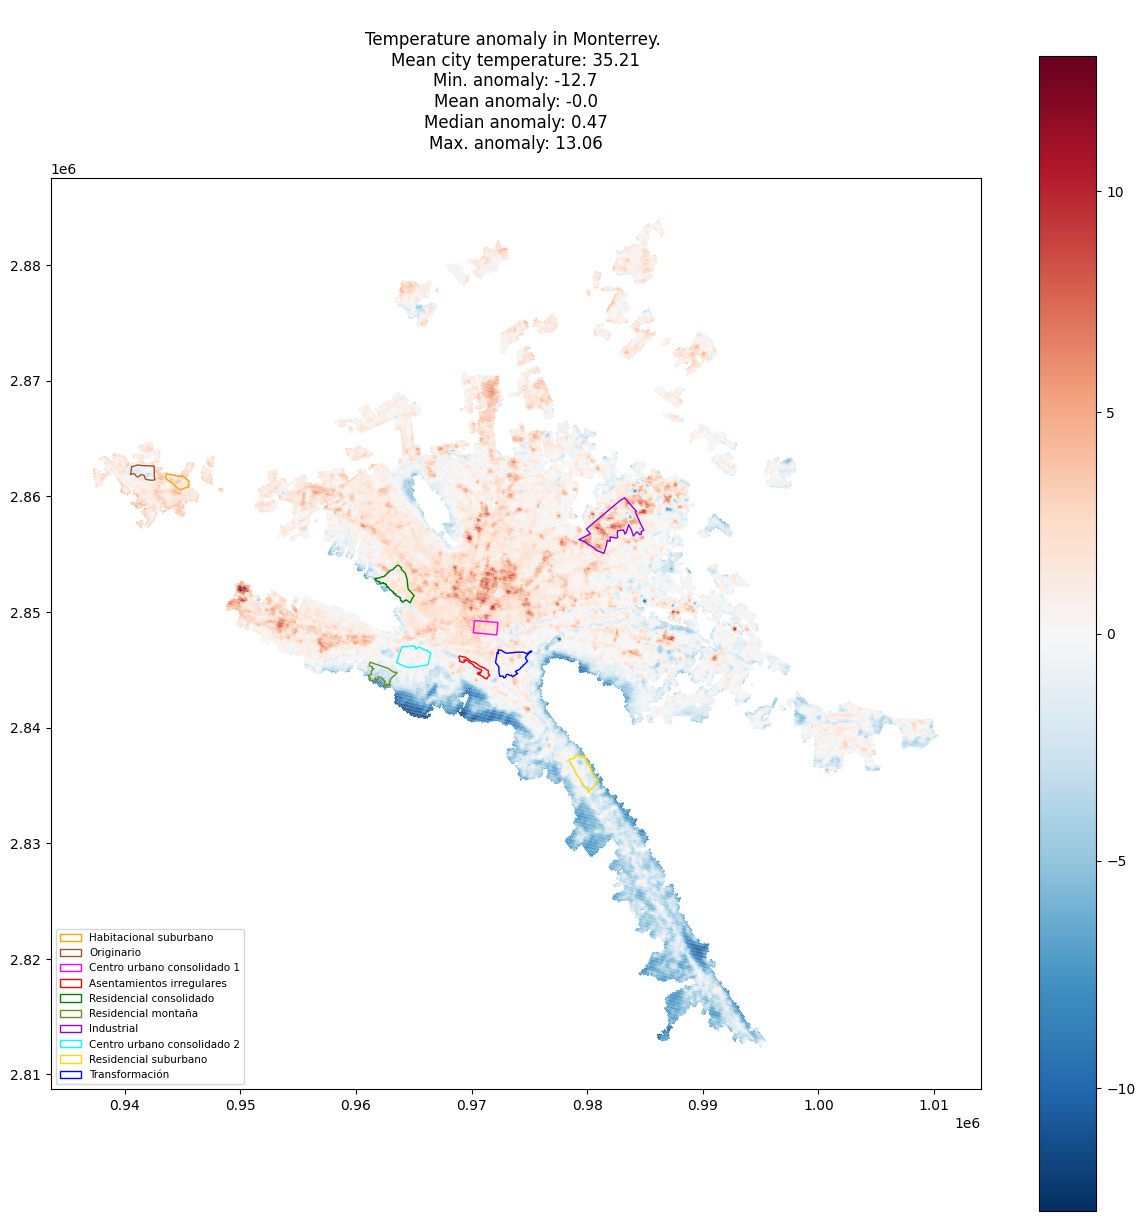

In [12]:
# Calculate anomaly (differential between mean in each hex and city mean)
mean_city_temperature = temperature_gdf.temperature_mean.mean()
print(f"Mean temperature in {city}: {mean_city_temperature}.")
temperature_gdf['temperature_anomaly'] = temperature_gdf['temperature_mean'] - mean_city_temperature

# Calculate main data of interest
min_anomaly = round(temperature_gdf.temperature_anomaly.min(),2)
mean_anomaly = round(temperature_gdf.temperature_anomaly.mean(),2)
median_anomaly = round(temperature_gdf.temperature_anomaly.median(),2)
max_anomaly = round(temperature_gdf.temperature_anomaly.max(),2)

# Prepare plot
fig,ax = plt.subplots(figsize = (15,15))

# Set colors for zones
color_dict = {'Habitacional suburbano':'orange',
              'Originario':'sienna',
              'Centro urbano consolidado 1':'fuchsia',
              'Asentamientos irregulares':'red',
              'Residencial consolidado':'green',
              'Residencial montaña':'olivedrab',
              'Industrial':'darkviolet',
              'Centro urbano consolidado 2':'cyan',
              'Residencial suburbano':'gold',
              'Transformación':'blue'}
urban_typ['color'] = urban_typ['name'].map(color_dict)

# Set color ranges (Specially 0 = white) for temperature_gdf
divnorm=colors.TwoSlopeNorm(vmin = temperature_gdf.temperature_anomaly.min(), 
                            vcenter = 0, 
                            vmax = temperature_gdf.temperature_anomaly.max()
                           )
# Plot
urban_typ.plot('name', 
               #legend=True,
               #legend_kwds={'fontsize':7.5,'loc':'lower left'},
               ax=ax,
               zorder=1,
               facecolor="none", 
               lw=1,
               edgecolor=urban_typ['color']
              )

temperature_gdf.plot('temperature_anomaly',
                     legend=True, 
                     cmap='RdBu_r',
                     norm=divnorm,
                     zorder=0,
                     ax=ax)

import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(edgecolor=color, facecolor='none', label=site, linewidth=1)
    for site, color in color_dict.items()
]
ax.legend(handles=legend_handles, fontsize=7.5, loc='lower left')

# Format
ax.set_title(f"""
Temperature anomaly in {city}. 
Mean city temperature: {round(mean_city_temperature,2)}
Min. anomaly: {min_anomaly}
Mean anomaly: {mean_anomaly}
Median anomaly: {median_anomaly}
Max. anomaly: {max_anomaly}
"""
)

# Save plot
#if save_plots:
#    plt.savefig(str(project_root)+f"/output/figures/temperature/2025_check/mty_anomaly_mean.svg")

### __Analysis 02__ Temperature, NDVI and NDMI behaviour in city

#### Filter NDMI for zones with vegetation

In [13]:
# Create vegetation categories
ndvi_gdf['ndvi_median_range'] = np.nan
ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_range'] = 'Alta densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
             (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_range'] = 'Moderada densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
             (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_range'] = 'Mínima densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
             (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_range'] = 'Suelo'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_range'] = 'Suelo artificial/Agua/Piedra'

# Order data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_gdf['ndvi_median_range'] = pd.Categorical(ndvi_gdf['ndvi_median_range'], categories=categories, ordered=True)

# Find hex_ids with vegetation
veg_categories = ['Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
hexs_with_veg = list(ndvi_gdf.loc[ndvi_gdf.ndvi_median_range.isin(veg_categories)].hex_id.unique())
print(f"Hexs with vegetation: {len(hexs_with_veg)} out of {len(ndvi_gdf)}.")

# Filter NDMI data
ndmi_veg_gdf = ndmi_gdf.loc[ndmi_gdf.hex_id.isin(hexs_with_veg)].copy()

# Show
print(ndmi_veg_gdf.shape)
ndmi_veg_gdf.head(2)

Hexs with vegetation: 25598 out of 58103.
(25598, 17)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndmi_2018,ndmi_2019,ndmi_2020,ndmi_2021,ndmi_2022,ndmi_2023,city
278,8a48a200201ffff,"POLYGON ((982767.02 2843712.513, 982833.562 28...",10,0.038043,0.025537,0.037655,0.076370,-0.002141,0.07851,-0.000233,0.043267,0.045202,0.053004,0.032039,0.023989,0.030757,Monterrey
281,8a48a2002037fff,"POLYGON ((982794.296 2843465.604, 982860.839 2...",10,0.034482,0.025246,0.031585,0.073787,-0.004883,0.07867,0.000240,0.018496,0.037162,0.051065,0.031682,0.028726,0.039761,Monterrey


#### Statistical summary

In [76]:
# Temperature data years
temp_data_years = ['temperature_2018', 'temperature_2019', 'temperature_2020', 'temperature_2021', 'temperature_2022', 'temperature_2023']
# Aggregate statistics
temp_stats = temperature_gdf[temp_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
temp_stats.rename(columns={'temperature_2018':2018,
                           'temperature_2019':2019,
                           'temperature_2020':2020,
                           'temperature_2021':2021,
                           'temperature_2022':2022,
                           'temperature_2023':2023},inplace=True)
# Transpose data
temp_stats_transposed = temp_stats.transpose()
temp_stats_transposed.drop(columns=['std'],inplace=True)

# Show
temp_stats_transposed

,min,mean,median,max
2018,20.700000,35.223225,36.148438,48.704687
2019,4.196691,34.455188,35.172222,47.506510
2020,20.648150,34.103952,34.645833,47.864583
2021,20.133821,34.770020,35.253788,48.851389
2022,17.971326,33.404087,33.676471,46.584201
2023,25.015323,38.452786,39.032500,53.920161


In [77]:
# NDVI data years
ndvi_data_years = ['ndvi_2018', 'ndvi_2019', 'ndvi_2020', 'ndvi_2021', 'ndvi_2022', 'ndvi_2023']
# Aggregate statistics
ndvi_stats = ndvi_gdf[ndvi_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
ndvi_stats.rename(columns={'ndvi_2018':2018,
                           'ndvi_2019':2019,
                           'ndvi_2020':2020,
                           'ndvi_2021':2021,
                           'ndvi_2022':2022,
                           'ndvi_2023':2023},inplace=True)
# Transpose data
ndvi_stats_transposed = ndvi_stats.transpose()
ndvi_stats_transposed.drop(columns=['std'],inplace=True)

# Show
ndvi_stats_transposed

,min,mean,median,max
2018,-0.512221,0.280449,0.219480,0.852642
2019,-0.572252,0.275865,0.209668,0.850863
2020,-0.584703,0.269375,0.207888,0.861792
2021,-0.402210,0.225111,0.169943,0.756553
2022,-0.149865,0.149149,0.113296,0.546572
2023,-0.069859,0.152304,0.117413,0.536950


In [78]:
# NDMI data years
ndmi_data_years = ['ndmi_2018', 'ndmi_2019', 'ndmi_2020', 'ndmi_2021', 'ndmi_2022', 'ndmi_2023']
# Aggregate statistics
ndmi_stats = ndmi_veg_gdf[ndmi_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
ndmi_stats.rename(columns={'ndmi_2018':2018,
                           'ndmi_2019':2019,
                           'ndmi_2020':2020,
                           'ndmi_2021':2021,
                           'ndmi_2022':2022,
                           'ndmi_2023':2023},inplace=True)
# Transpose data
ndmi_stats_transposed = ndmi_stats.transpose()
ndmi_stats_transposed.drop(columns=['std'],inplace=True)

# Show
ndmi_stats_transposed

,min,mean,median,max
2018,-0.217217,0.051739,0.045604,0.305782
2019,-0.205447,0.050905,0.044901,0.317698
2020,-0.234891,0.049921,0.043217,0.333218
2021,-0.274482,0.017466,0.015242,0.273573
2022,-0.197810,0.003455,0.002224,0.205470
2023,-0.160724,0.015567,0.012652,0.203873


#### Plot

Text(0, 0.5, 'Mean NDMI')

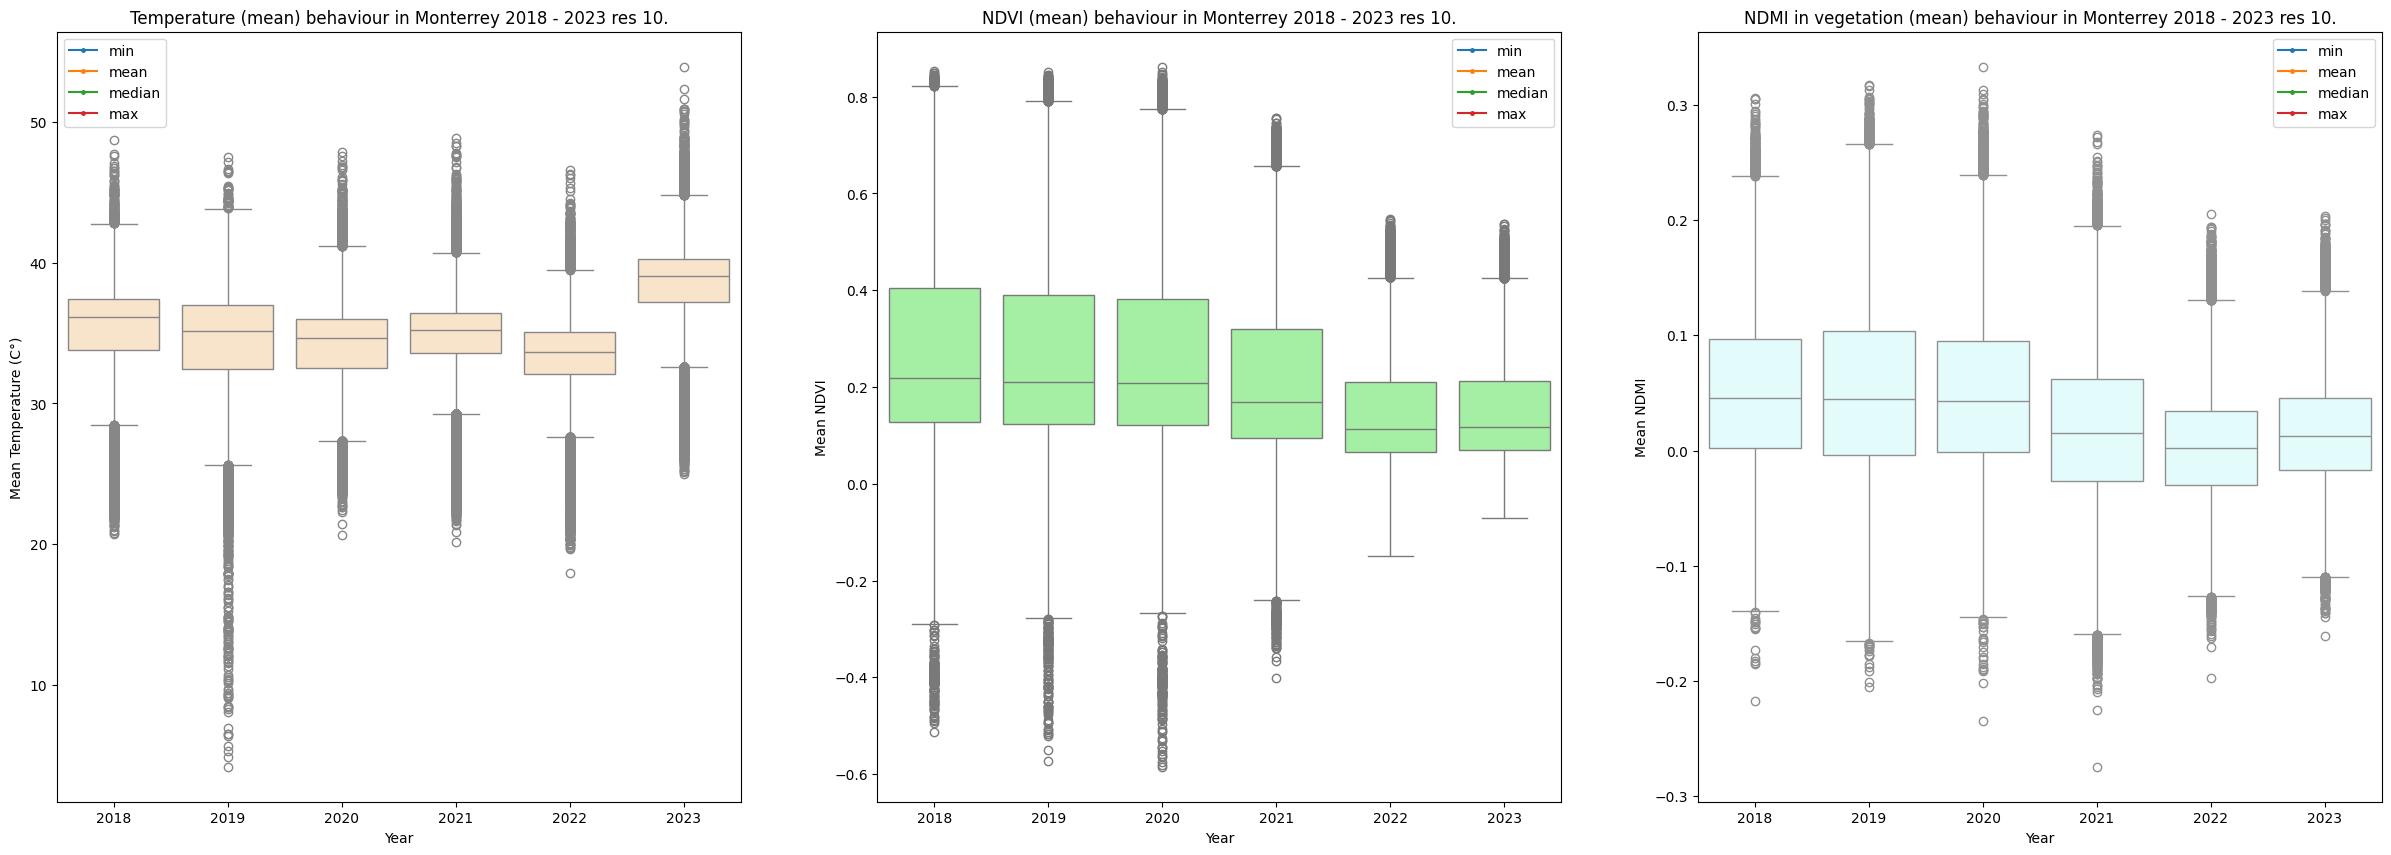

In [79]:
years = np.array([2018, 2019, 2020, 2021, 2022, 2023])

fig, axs = plt.subplots(1,3,figsize=(30,10))

# ---------- Temperature Boxplot data ----------
temperature_yearsummary = pd.DataFrame()
for year in years:
    # Extract year's data
    temperature_year = temperature_gdf[[f'temperature_{year}']].copy()
    # Rename column
    temperature_year.rename(columns={f'temperature_{year}':'temperature'},inplace=True)
    # Add year col
    temperature_year['year'] = year
    # Concat
    temperature_yearsummary = pd.concat([temperature_yearsummary,temperature_year])

# ---------- NDVI Boxplot data ----------
ndvi_yearsummary = pd.DataFrame()
for year in years:
    # Extract year's data
    ndvi_year = ndvi_gdf[[f'ndvi_{year}']].copy()
    # Rename column
    ndvi_year.rename(columns={f'ndvi_{year}':'ndvi'},inplace=True)
    # Add year col
    ndvi_year['year'] = year
    # Concat
    ndvi_yearsummary = pd.concat([ndvi_yearsummary,ndvi_year])

# ---------- NDMI Boxplot data ----------
ndmi_yearsummary = pd.DataFrame()
for year in years:
    # Extract year's data
    ndmi_year = ndmi_veg_gdf[[f'ndmi_{year}']].copy()
    # Rename column
    ndmi_year.rename(columns={f'ndmi_{year}':'ndmi'},inplace=True)
    # Add year col
    ndmi_year['year'] = year
    # Concat
    ndmi_yearsummary = pd.concat([ndmi_yearsummary,ndmi_year])

# ---------- PLOT ----------
temp_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[0],zorder=1)
sns.boxplot(x=np.array(temperature_yearsummary.year), 
            y=np.array(temperature_yearsummary.temperature),
            zorder=0,
            color='bisque',
            ax=axs[0])

# Plot NDVI
ndvi_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[1],zorder=1)
sns.boxplot(x=np.array(ndvi_yearsummary.year), 
            y=np.array(ndvi_yearsummary.ndvi),
            color='palegreen',
            zorder=0,
            ax=axs[1])

# Plot NDMI
ndmi_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[2],zorder=1)
sns.boxplot(x=np.array(ndmi_yearsummary.year), 
            y=np.array(ndmi_yearsummary.ndmi),
            color='lightcyan',
            zorder=0,
            ax=axs[2])

# ---------- FORMAT ----------
# Format - Main titles
axs[0].set_title(f'Temperature (mean) behaviour in {city} 2018 - 2023 res {res}.')
axs[1].set_title(f'NDVI (mean) behaviour in {city} 2018 - 2023 res {res}.')
axs[2].set_title(f'NDMI in vegetation (mean) behaviour in {city} 2018 - 2023 res {res}.')

# Format - Axis titles
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Mean Temperature (C°)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean NDVI')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Mean NDMI')

# Save plot
#if save_plots:
#    plt.savefig(str(project_root)+f"/output/figures/temperature/2025_check/temp_ndvi_ndmi_yearlybehaviour.svg")

### __Analysis 03__ Mean temperature, NDVI and NDMI by typology

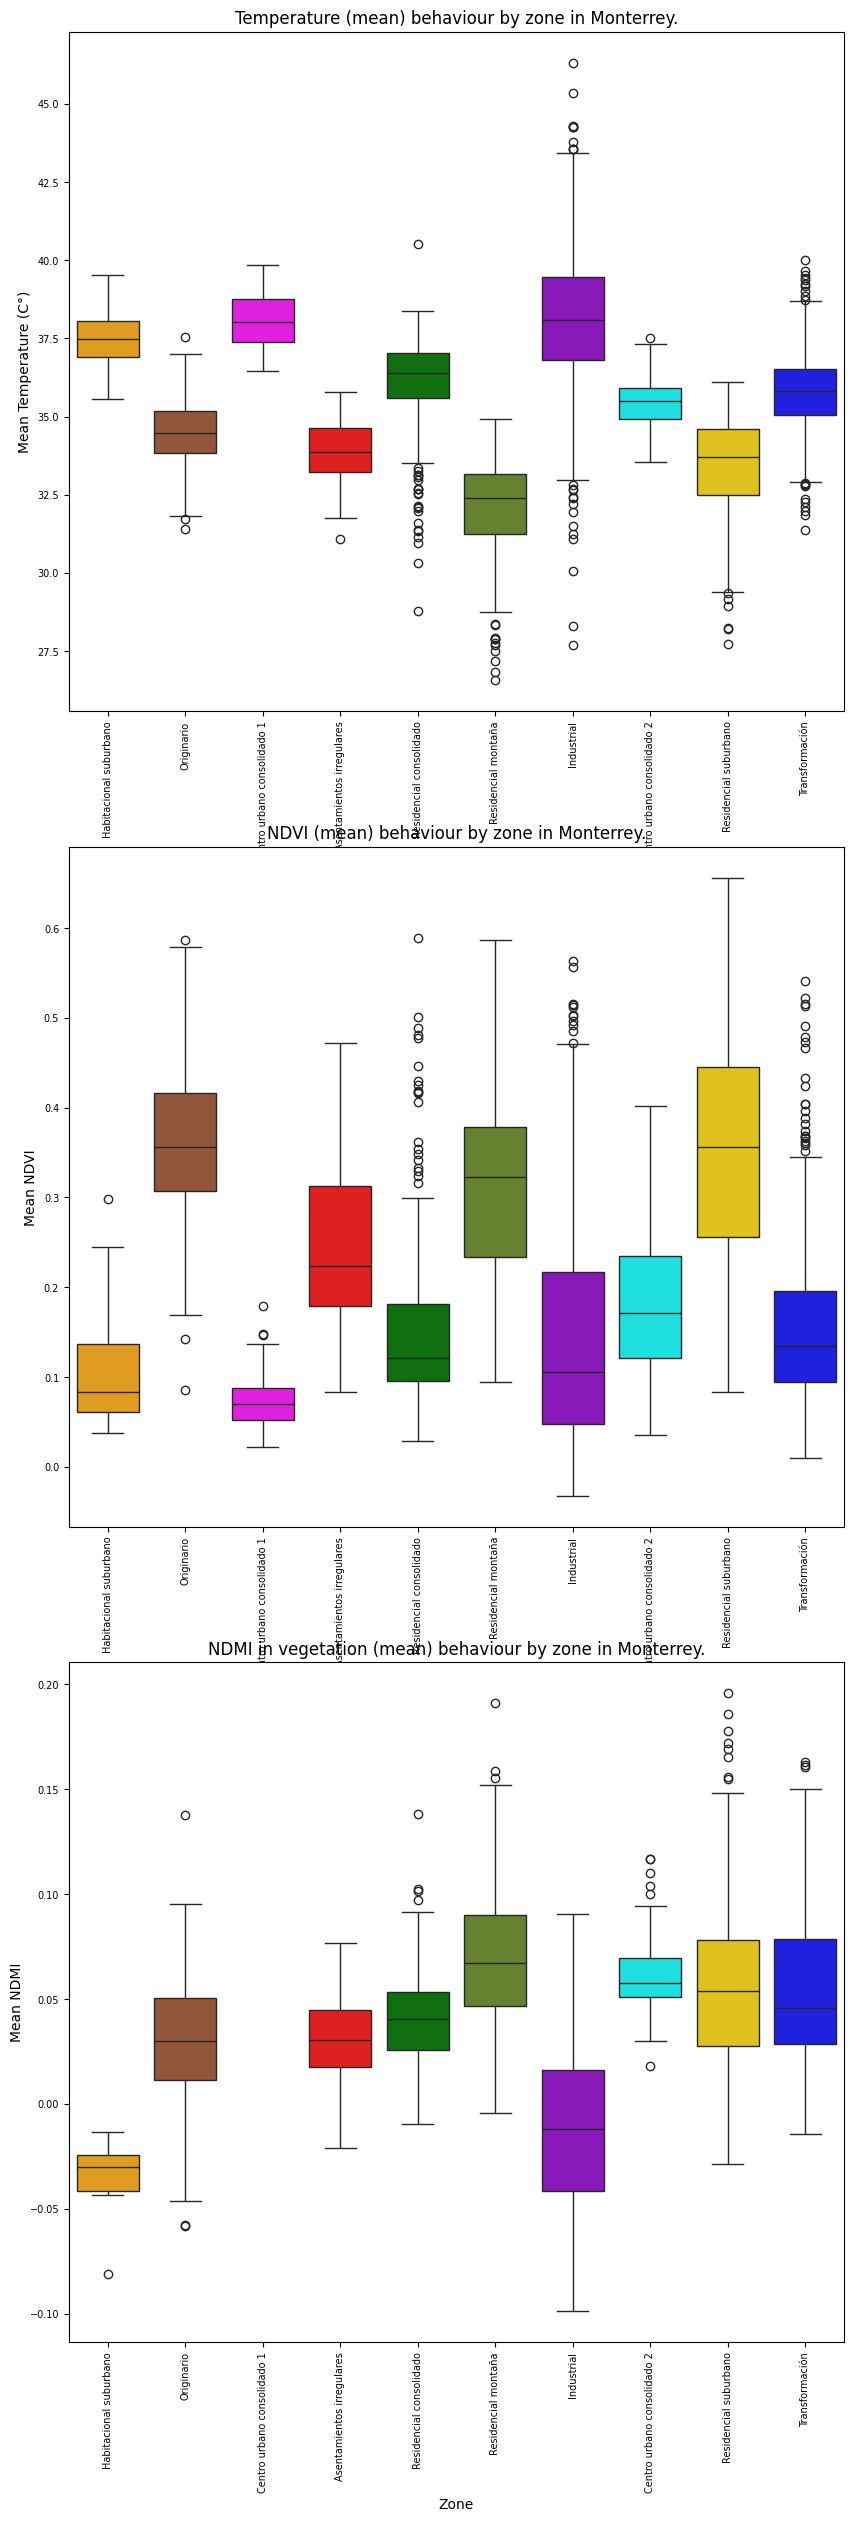

In [18]:
fig,axs = plt.subplots(3,1,figsize=(10,30))

zones = list(urban_typ.name.unique())

# ---------- Temperature Boxplot data ----------
temperature_zonesummary = pd.DataFrame()
for zone in zones:
    # Select zone
    zone_gdf = urban_typ.loc[urban_typ.name==zone].copy()
    # Find zone's data
    zone_temp_gdf = gpd.sjoin(zone_gdf, temperature_gdf[['temperature_mean','geometry']],how='left')
    # Extract zone's data
    temperature_zone = zone_temp_gdf[[f'temperature_mean']].copy()
    # Rename column
    temperature_zone.rename(columns={f'temperature_mean':'temperature'},inplace=True)
    # Add year col
    temperature_zone['zone'] = zone
    # Concat
    temperature_zonesummary = pd.concat([temperature_zonesummary,temperature_zone])

# ---------- NDVI Boxplot data ----------
ndvi_zonesummary = pd.DataFrame()
for zone in zones:
    # Select zone
    zone_gdf = urban_typ.loc[urban_typ.name==zone].copy()
    # Find zone's data
    zone_ndvi_gdf = gpd.sjoin(zone_gdf, ndvi_gdf[['ndvi_mean','geometry']],how='left')
    # Extract zone's data
    ndvi_zone = zone_ndvi_gdf[[f'ndvi_mean']].copy()
    # Rename column
    ndvi_zone.rename(columns={f'ndvi_mean':'ndvi'},inplace=True)
    # Add year col
    ndvi_zone['zone'] = zone
    # Concat
    ndvi_zonesummary = pd.concat([ndvi_zonesummary,ndvi_zone])

# ---------- NDMI Boxplot data ----------
ndmi_zonesummary = pd.DataFrame()
for zone in zones:
    # Select zone
    zone_gdf = urban_typ.loc[urban_typ.name==zone].copy()
    # Find zone's data
    zone_ndmi_gdf = gpd.sjoin(zone_gdf, ndmi_veg_gdf[['ndmi_mean','geometry']],how='left')
    # Extract zone's data
    ndmi_zone = zone_ndmi_gdf[[f'ndmi_mean']].copy()
    # Rename column
    ndmi_zone.rename(columns={f'ndmi_mean':'ndmi'},inplace=True)
    # Add year col
    ndmi_zone['zone'] = zone
    # Concat
    ndmi_zonesummary = pd.concat([ndmi_zonesummary,ndmi_zone])

# ---------- PLOT ----------
# Plot Temperature
sns.boxplot(x=np.array(temperature_zonesummary.zone), 
            y=np.array(temperature_zonesummary.temperature),
            zorder=0,
            palette=color_dict,
            ax=axs[0])
# Plot NDVI
sns.boxplot(x=np.array(ndvi_zonesummary.zone), 
            y=np.array(ndvi_zonesummary.ndvi),
            zorder=0,
            palette=color_dict,
            ax=axs[1])
# Plot NDMI
sns.boxplot(x=np.array(ndmi_zonesummary.zone), 
            y=np.array(ndmi_zonesummary.ndmi),
            zorder=0,
            palette=color_dict,
            ax=axs[2])

# ---------- FORMAT ----------
# Format - Main titles
axs[0].set_title(f'Temperature (mean) behaviour by zone in {city}.')
axs[1].set_title(f'NDVI (mean) behaviour by zone in {city}.')
axs[2].set_title(f'NDMI in vegetation (mean) behaviour by zone in {city}.')

# Format - Axis titles
axs[0].set_xlabel('Zone')
axs[0].set_ylabel('Mean Temperature (C°)')
axs[1].set_xlabel('Zone')
axs[1].set_ylabel('Mean NDVI')
axs[2].set_xlabel('Zone')
axs[2].set_ylabel('Mean NDMI')

# Format - Ticks
for ax in axs:
    # X axis
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_size(7)
    # Y axis
    for label in ax.get_yticklabels():
        label.set_size(7)

### __Analysis 04__ Temperature, NDVI and NDMI slope by typology

In [27]:
# Slope function
def calc_slope(row, cols):
    data = row[cols].astype(float).values
    slope, intercept = np.polyfit(years, data, 1)
    return slope

Zone Habitacional suburbano's Temperature slope: 0.09317464734811264.
Zone Originario's Temperature slope: 0.6150998585826585.
Zone Centro urbano consolidado 1's Temperature slope: 0.37847549382187495.
Zone Asentamientos irregulares's Temperature slope: 0.29480871496178357.
Zone Residencial consolidado's Temperature slope: 0.1296350125085504.
Zone Residencial montaña's Temperature slope: 0.07130004222787985.
Zone Industrial's Temperature slope: 0.6185614168721891.
Zone Centro urbano consolidado 2's Temperature slope: 0.24918880939002175.
Zone Residencial suburbano's Temperature slope: 0.537749572487536.
Zone Transformación's Temperature slope: 0.5205399025211864.
----------------------------------------------------------------------------------------------------
Zone Habitacional suburbano's NDVI slope: -0.010605524262913134.
Zone Originario's NDVI slope: -0.053498902496182166.
Zone Centro urbano consolidado 1's NDVI slope: -0.009219399273445828.
Zone Asentamientos irregulares's NDVI s

Text(0.5, 1.0, 'NDMI in vegetation means(2018-2023).')

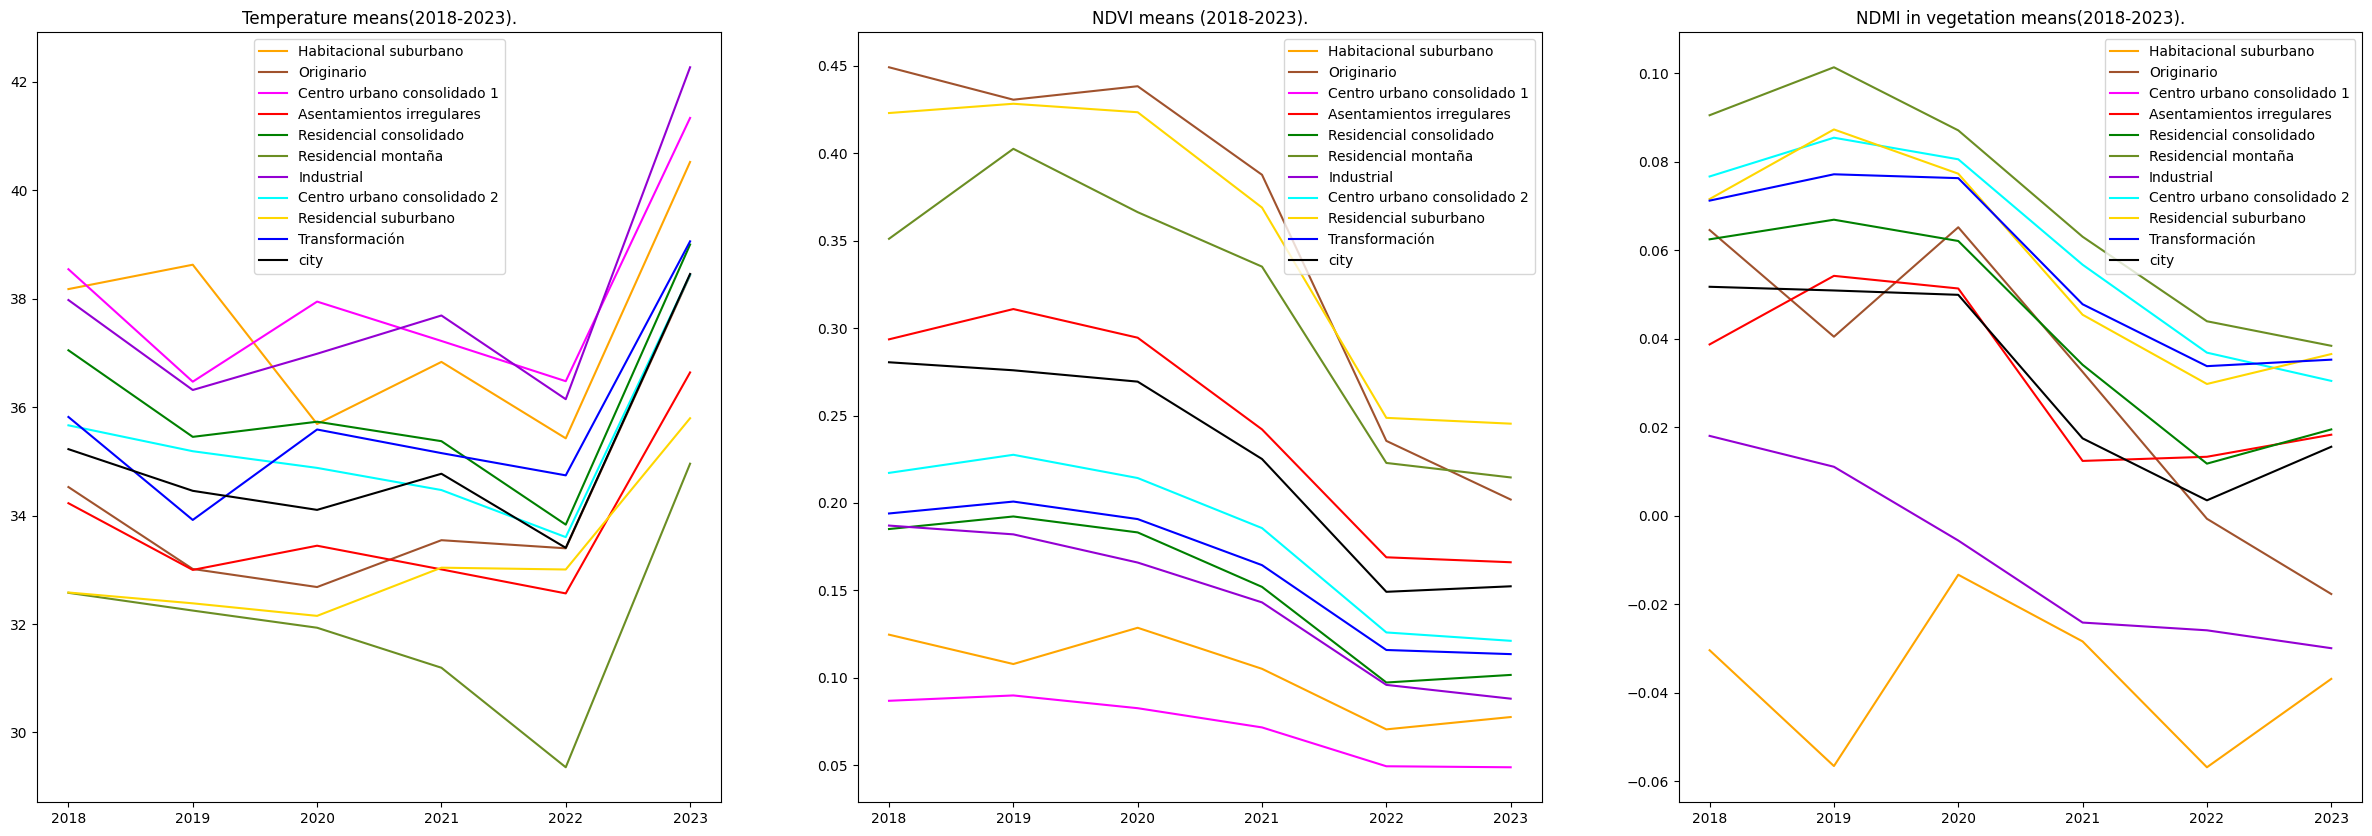

In [95]:
years = np.array([2018, 2019, 2020, 2021, 2022, 2023])

# Add city to color dict
color_dict_city = color_dict.copy()
color_dict_city['city']='black'
color_dict_city

# ---------- Temperature Mean and Slope data ----------
temperature_zone_slope = pd.DataFrame()
temp_columns = [f'temperature_{year}' for year in years]
for zone in zones:
    # Select zone
    zone_gdf = urban_typ.loc[urban_typ.name==zone].copy()
    # Find zone's data
    zone_temp_gdf = gpd.sjoin(zone_gdf, temperature_gdf[temp_columns + ['geometry']],how='left')
    # Calculate zone's slope
    zone_temp_gdf['temperature_slope'] = zone_temp_gdf.apply(calc_slope, args=(temp_columns,), axis=1)
    mean_zone_slope = zone_temp_gdf.temperature_slope.mean()
    print(f"Zone {zone}'s Temperature slope: {mean_zone_slope}.")
    # Find mean by year (for plot)
    for year in years:
        zone_mean = zone_temp_gdf[f'temperature_{year}'].mean()
        temperature_zone_slope.loc[year,zone] = zone_mean
# Add city as reference
temperature_zone_slope = temperature_zone_slope.merge(temp_stats_transposed['mean'], left_index=True, right_index=True)
temperature_zone_slope.rename(columns={'mean':'city'},inplace=True)
print("--"*50)

# ---------- NDVI Mean and Slope data ----------
ndvi_zone_slope = pd.DataFrame()
ndvi_columns = [f'ndvi_{year}' for year in years]
for zone in zones:
    # Select zone
    zone_gdf = urban_typ.loc[urban_typ.name==zone].copy()
    # Find zone's data
    zone_ndvi_gdf = gpd.sjoin(zone_gdf, ndvi_gdf[ndvi_columns + ['geometry']],how='left')
    # Calculate zone's slope
    zone_ndvi_gdf['ndvi_slope'] = zone_ndvi_gdf.apply(calc_slope, args=(ndvi_columns,), axis=1)
    mean_zone_slope = zone_ndvi_gdf.ndvi_slope.mean()
    print(f"Zone {zone}'s NDVI slope: {mean_zone_slope}.")
    # Find mean by year (for plot)
    for year in years:
        zone_mean = zone_ndvi_gdf[f'ndvi_{year}'].mean()
        ndvi_zone_slope.loc[year,zone] = zone_mean
# Add city as reference
ndvi_zone_slope = ndvi_zone_slope.merge(ndvi_stats_transposed['mean'], left_index=True, right_index=True)
ndvi_zone_slope.rename(columns={'mean':'city'},inplace=True)
print("--"*50)

# ---------- NDMI Mean and Slope data ----------
ndmi_zone_slope = pd.DataFrame()
ndmi_columns = [f'ndmi_{year}' for year in years]
for zone in zones:
    # Select zone
    zone_gdf = urban_typ.loc[urban_typ.name==zone].copy()
    # Find zone's data
    zone_ndmi_gdf = gpd.sjoin(zone_gdf, ndmi_veg_gdf[ndmi_columns + ['geometry']],how='left')
    # Calculate zone's slope
    zone_ndmi_gdf['ndmi_slope'] = zone_ndmi_gdf.apply(calc_slope, args=(ndmi_columns,), axis=1)
    mean_zone_slope = zone_ndmi_gdf.ndmi_slope.mean()
    print(f"Zone {zone}'s NDMI slope: {mean_zone_slope}.")
    # Find mean by year (for plot)
    for year in years:
        zone_mean = zone_ndmi_gdf[f'ndmi_{year}'].mean()
        ndmi_zone_slope.loc[year,zone] = zone_mean
# Add city as reference
ndmi_zone_slope = ndmi_zone_slope.merge(ndmi_stats_transposed['mean'], left_index=True, right_index=True)
ndmi_zone_slope.rename(columns={'mean':'city'},inplace=True)
print("--"*50)

# --- --- --- --- --- Plot Means
# Show
fig,axs = plt.subplots(1,3,figsize=(30,10))

# --- Plots
# Temperature
temperature_zone_slope.plot(color=color_dict_city,
                            ax=axs[0])
# NDVI
ndvi_zone_slope.plot(color=color_dict_city,
                     ax=axs[1])
# NDMI
ndmi_zone_slope.plot(color=color_dict_city,
                     ax=axs[2])


# Format
axs[0].set_title(f"Temperature means(2018-2023).")
axs[1].set_title(f"NDVI means (2018-2023).")
axs[2].set_title(f"NDMI in vegetation means(2018-2023).")

# Save plot
#if save_plots:
#    plt.savefig(str(project_root)+f"/output/figures/temperature/2025_check/temp_ndvi_ndmi_slope.svg")"""